# Problem Set #4: Synchrony and Oscillations
**DUE 12 May 2021 - NEU 502A**

**Submission Directions:** Prior to submitting, clear you kernel and run through all your cells in order so figures and variables are accurately recorded. Only include cells with necessary code or answers, do not include cells used for troubleshooting. Email this notebook with your last name in the filename to Eleni (elenip@princeton.edu) by 5pm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colorbar
from matplotlib.patches import Rectangle
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

# hilbert transform
from scipy.signal import hilbert

%matplotlib inline
sns.set_context('talk')

<big><strong> Modeling the Effect of Synchrony on Information Transfer  </strong></big>

<br>
<body>
    In this problem set we will model the impact of synchronized neural activity on the transfer of information between networks.  All neurons will be modeled using Izhikevich's model (<i>Simple Models of Neural Networks</i> in IEEE Transactions on Neural Networks. Vol. 14. No. 6.  November 2003).
<br>
<br>
    Izhikevich's neurons are not biophysical models.  Rather, they are a pair of simple differential equations that are meant to capture the rich dynamics you see in neurons in a reduced (easy to calculate) system.  The differential equations govern the evolutation of two variables $v$ and $u$ over time:<br>
    $$C \frac{\partial v}{\partial t} = 0.04v^2 + 5v + 140 - u + S$$<br>
    $$\frac{\partial u}{\partial t} = a(bv - u)$$<br>
    $$\text{if } v \ge v_{thresh}, \text{ then set } v = c \text{ and } u = u + d$$<br>
where $v$ represents the neuron's membrane voltage and $u$ represents a membrane recovery variable. The third line in the above equations specifies that when a spike occurs ($v \ge v_{thresh}$), then set $v=c$ and $u = u + d$. Here, we set the threshold to $v_{thresh}=30$ mV. 
<br>
<br>
In the model, the variables $v$ and $u$ are initialized to $v_0 = -65 mV$ and $u_0 = bv_0$. The parameters $a$, $b$, $c$, and $d$ are roughly, in order: the time constant for recovery, a constant related to the conductance of the neuron, the reset value of the membrane (after a spike), and the flux in currents after a spike. These will change for different neuron types. First, we will use $a=0.02$, $b=0.25$, $c=-57.5\pm7.5$, and $d=1.5\pm0.25$ for 'excitatory' neurons and $a=0.16\pm0.04$, $b=0.275\pm0.025$, $c=-65$, and $d=2$ for 'inhibitory' interneurons. 
<br>
<br>
Finally, $S$ is the synaptic drive into a neuron, either from its connections to other simulated neurons or from external drive.  
<br>
<br>
We will begin by simulating a population of neurons with varying oscillatory inputs and measuring the neuron's responses. The following block of code does this.
</body>

In [2]:
"""
This code simulates a population of neurons with varying oscillatory inputs. 
Run this code before moving onto the first question.
"""
# Define the number of neurons in our two populations
N_exc = 1000
N_inh = 200

# Simulation time - time step will be 1 ms
T = 1000 #in milliseconds

# Initialize some random arrays for generating some diversity in our neuron subtypes
perturb_exc = np.random.rand(N_exc)
perturb_inh = np.random.rand(N_inh)

# Define our cell parameters
a = np.concatenate((0.02*np.ones(N_exc), 0.12 + 0.08*perturb_inh))
b = np.concatenate((0.25*np.ones(N_exc), 0.3 - 0.05*perturb_inh))
c = np.concatenate((-65 + 15*perturb_exc, -65*np.ones(N_inh)))
d = np.concatenate((2 - 0.5*perturb_exc, 2*np.ones(N_inh)))

# Initialize the v and u variables
v = -65*np.ones(N_exc + N_inh) + 20*(np.random.rand(N_exc + N_inh) - 0.5)
u = b*v

# Initialize variable to keep track of spiking events for our neurons
spks = np.zeros((N_exc+N_inh, T))

# External input will be a sinusoid with some noise
ext_inp_f = 10 #in Hz
ext_inp_rel_str = 0.1
ext_inp = np.sin(np.arange(T)/1000*2*np.pi*ext_inp_f)

# Simulate our network
for t in range(T):
    # Find which neurons are above spiking threshold
    spks[v>=30,t] = 1
    # Reset these neurons v and u variables
    v[spks[:,t]==1] = c[spks[:,t]==1]
    u[spks[:,t]==1] = u[spks[:,t]==1] + d[spks[:,t]==1]
    
    # Calculate the input to the cells
    S = ext_inp_rel_str*ext_inp[t]*np.concatenate((5*np.ones(N_exc), 2*np.ones(N_inh))) + \
        (1-ext_inp_rel_str)*np.concatenate((5*np.ones(N_exc), 2*np.ones(N_inh)))*np.random.randn(N_exc + N_inh)
    
    # Update our variables -- do half ms integration of v for stability
    v = v + 0.5 * (0.04*np.power(v, 2) + 5*v + 140 - u + S)
    v = v + 0.5 * (0.04*np.power(v, 2) + 5*v + 140 - u + S)
    u = u + a*(b*v - u)


<br><big><strong> Plotting the effect of Oscillatory Inputs on Responses </strong></big>

<body>
We can examine the influence of oscillations on spiking activity by plotting the sinusoidal input alongside some example raster plots from a few neurons.  The code for this is provided below.  Obviously, examining each neuron in turn is not a great way to measure the impact of an oscillation.  A better way to examine this is to look at the average response of all neurons.  
<br>
**1.** Add code to plot the average number of spikes fired by excitatory neurons in each time bin in the second subplot below. Next, repeat this to plot the average number of spikes fired by inhibitory neurons in each time bin in the third subplot. That is, in both cases the averages are taken across all neurons of a given subtype, such that the ouput is a length T array (where T is the time of the simulation). Please label the plots accordingly.</i>
</body>

Text(0.5, 1.0, 'Inhibitory neurons')

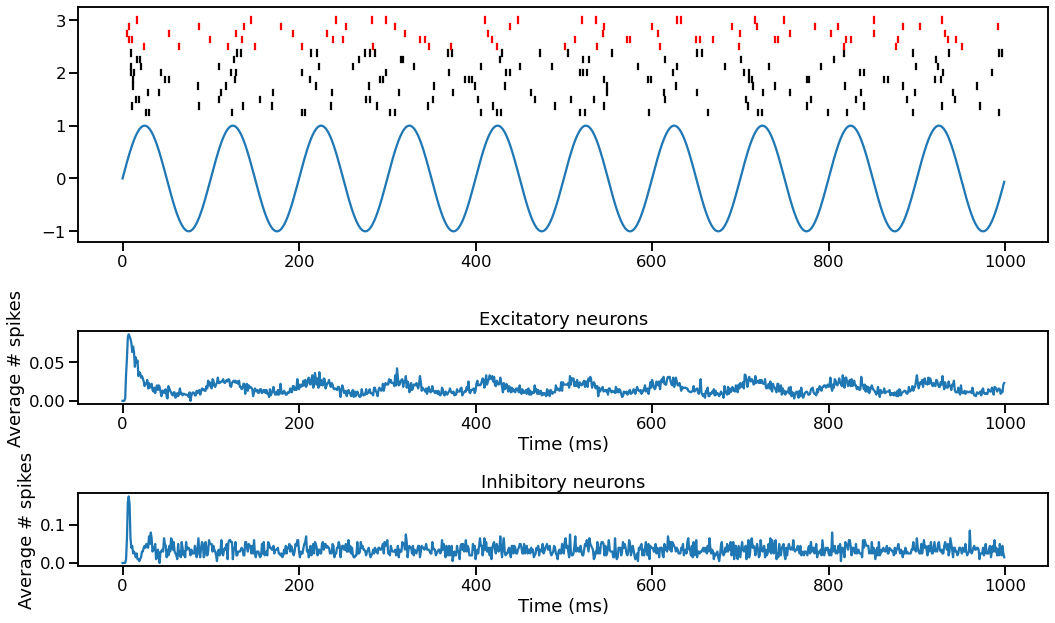

In [5]:
# Plot the spiking activity over time

fig = plt.figure(tight_layout=True, figsize=(15,9))
gs = gridspec.GridSpec(4, 1)

# Create a subplot for the raster plots
ax = fig.add_subplot(gs[0:2])

# Plot the sinusoidal input
plt.plot(range(T), ext_inp)

# Plot some spiking events for a random subset of excitatory neurons
count = 0
for i in np.random.randint(0, N_exc+1,size=(10,1)):
    for t_spk in np.flatnonzero(spks[i,:]):
        plt.plot(t_spk*np.array((1,1)), np.amax(ext_inp) + 0.2 + count*0.125 + np.array((0,0.1)), 'k')
    count += 1
    
# Plot some spiking events for a random subset of inhibitory neurons
count = 0
for i in np.random.randint(0, N_exc+1,size=(5,1)):
    for t_spk in np.flatnonzero(spks[i,:]):
        plt.plot(t_spk*np.array((1,1)), np.amax(ext_inp) + 0.2 + 10*0.125 + count*0.125 + np.array((0,0.1)), 'r')
    count += 1

"""
1. 
"""
# Plot the average response of excitatory neurons
ax = fig.add_subplot(gs[2])
## INSERT CODE HERE
x=np.arange(0,T)
ax.plot(x,np.mean(spks[0:N_exc,:], axis=0))
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Average # spikes")
ax.set_title("Excitatory neurons")

# Plot the average response of inhibitory neurons
ax = fig.add_subplot(gs[3])
## INSERT CODE HERE
x=np.arange(0,T)
ax.plot(x,np.mean(spks[N_exc:,:], axis=0))
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Average # spikes")
ax.set_title("Inhibitory neurons")



<big><strong>Statistical test of correlation</strong></big>
<br>
<br>
<body>
To statistically test the relationship between the oscillation and the spiking events, we can calculate the 'phase-locking value' (PLV) between the spiking events and the oscillation (our 'LFP' for now).  The logic of the PLV is simple: if the oscillation influences the activity of the neurons, then you would expect a consistent relationship between the phase of the oscillation and the spike times of neurons.  To test whether this is the case, we will estimate the phase of the oscillation for each spiking event.  If there is a consistent relationship, then the circular average of these phases should be greater than you expect by chance.
<br>
<br>
The PLV is defined as: $$PLV = \frac{1}{N_{spk}}\left|\sum_{t_{spk}}^{N_{spk}} e^{i\phi(t_{spk})}\right|$$
where $N_{spk}$ is the total number of spikes for a neuron, $t_{spk}$ are the spike times of that neuron, $i$ is the imaginary unit, $\left| \cdot \right|$ is the absolute value, and $\phi(t_{spk})$ is the phase of the oscillation at the time $t_{spk}$. The sum is taken over all of the spikes.
<br>
<br>
**2**. In the code below, calulate the PLV for each neuron and plot the distributions of PLV values separately for excitatory and inhibitory neurons. The plotting code is provided.
<br>
<br>
While there are some closed form estimates of the likelihood of observing a certain PLV value, most work compares the observed PLV to the distribution of randomly permuted PLVs, where each permuted PLV is calculated by randomly shuffling the relationship between spike events and the phase of the oscillation.  Usually this is done by shuffling across trials.  Here we aren't going to worry about significance.

Note, here we are using the output from a Hilbert transform to estimate the phase of the signal at each time point.  For real data, you would usually apply this after you've filtered your data to your signal of interest.  Alternatively, you could use a wavelet to estimate the phase of the signal within a specific time range (my personal favorite).
</body>

In [13]:
np.sum(spks[0])
len(np.flatnonzero(spks[0]))

16

Text(0, 0.5, 'Count')

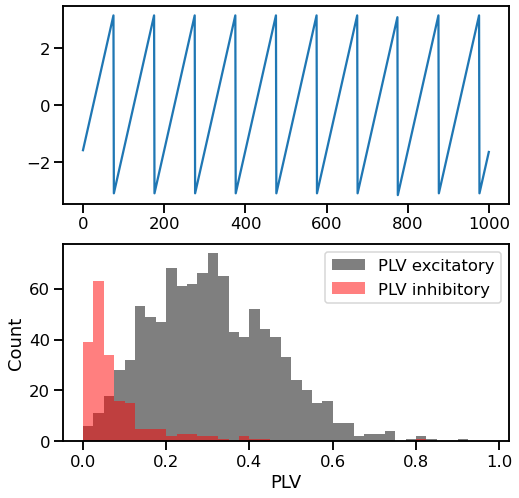

In [18]:
#Setup figure
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(2, 1)


#Estimate the phase of the LFP using a hilbert transform
ext_inp_phase = np.angle(hilbert(ext_inp))
ax = fig.add_subplot(gs[0])
plt.plot(np.arange(T), ext_inp_phase)

"""
2. 
"""

# Calculate the PLV for each neuron in turn
plv_exc = np.zeros(N_exc)
for i in np.arange(N_exc):
    sum=0
    ## INSERT CODE FOR CALCULATING PLV FOR EXCITATORY NEURONS HERE, FILLING IN plv_ecx
    t_spk=np.flatnonzero(spks[i,:])
    n_spk=len(t_spk)
    for time in t_spk:
        sum += np.exp(1j*ext_inp_phase[time])
    plv_exc[i]= np.abs(sum)/n_spk   

   
plv_inh = np.zeros(N_inh)
for i in np.arange(N_inh):
    sum=0 
    ## INSERT CODE FOR CALCULATING PLV FOR INHIBITORY NEURONS HERE, FILLING IN plv_inh
    t_spk=np.flatnonzero(spks[1000+i,:])
    n_spk=len(t_spk)
    for time in t_spk:
        sum += np.exp(1j*ext_inp_phase[time])
    plv_inh[i]= np.abs(sum)/n_spk   


# Plot the distribution of PLV values
ax = fig.add_subplot(gs[1])
plt.hist(plv_exc, bins=np.arange(0,1,0.025), alpha = 0.5, color= 'k', label='PLV excitatory')
plt.hist(plv_inh, bins=np.arange(0,1,0.025), alpha = 0.5, color= 'r', label='PLV inhibitory')
plt.legend()
plt.xlabel('PLV')
plt.ylabel('Count')


<big><strong>Measuring effect of oscillations across power and frequency</strong></big>
<br>
<br>
<body>
Now we are going to measure how strongly neurons are (on average) phase-locked to oscillations of different frequencies and strengths.  Below you are provided with all of the necessary code to simulate the influence of oscillations ranging from no input strength (<code>ext_inp_rel_str = 0</code>) to high input strength (<code>ext_inp_rel_str = 0.8</code>).  Make a reasonable number of steps in this space to capture the effect.

At the same time, let's measure the influence of different frequencies -- set <code>ext_inp_f</code> to 10, 20, 40, 80 and 160 Hz.
<br> 
<br>
**3.** Simulate the network with varying input strengths (set <code>ext_inp_rel_str </code> to 0, 0.2, 0.4, 0.6, 0.8) and with variables frequencies (set <code>ext_inp_f</code> to 10, 20, 40, 80 and 160 Hz.). You should have 25 simulations corresponding to each pair of input strength and frequency values. For each pair of values, calculate the average PLV separately for the excitatory and inhibitory neurons. Store the PLV values such that you can plot them in the next problem. 
    
</body>

In [19]:
"""
3. 
"""
# Calculate average PLV for simulations at varying oscillation strengths and frequencies.


#Define a function for calculating spiking response
def SimNetwork(ext_inp_f, ext_inp_rel_str, N_exc, N_inh, T):
    # Initialize some random arrays for generating some diversity in our neuron subtypes
    perturb_exc = np.random.rand(N_exc)
    perturb_inh = np.random.rand(N_inh)

    # Define our cell parameters
    a = np.concatenate((0.02*np.ones(N_exc), 0.12 + 0.08*perturb_inh))
    b = np.concatenate((0.25*np.ones(N_exc), 0.3 - 0.05*perturb_inh))
    c = np.concatenate((-65 + 15*perturb_exc, -65*np.ones(N_inh)))
    d = np.concatenate((2 - 0.5*perturb_exc, 2*np.ones(N_inh)))

    # Initialize the v and u variables
    v = -65*np.ones(N_exc + N_inh) + 20*(np.random.rand(N_exc + N_inh) - 0.5)
    u = b*v

    # Initialize variable to keep track of spiking events for our neurons
    spks = np.zeros((N_exc+N_inh, T))
    # External input will be a sinusoid with some noise
    #ext_inp_f = 10 #in Hz
    #ext_inp_rel_str = 0.1
    ext_inp = np.sin(np.arange(T)/1000*2*np.pi*ext_inp_f)

    # Simulate our network
    for t in range(T):
        # Find which neurons are above spiking threshold
        spks[v>=30,t] = 1
        # Reset these neurons v and u variables
        v[spks[:,t]==1] = c[spks[:,t]==1]
        u[spks[:,t]==1] = u[spks[:,t]==1] + d[spks[:,t]==1]

        # Calculate the input to the cells
        S = ext_inp_rel_str*ext_inp[t]*np.concatenate((5*np.ones(N_exc), 2*np.ones(N_inh))) + \
            (1-ext_inp_rel_str)*np.concatenate((5*np.ones(N_exc), 2*np.ones(N_inh)))*np.random.randn(N_exc + N_inh)

        # Update our variables -- do half ms integration of v for stability
        v = v + 0.5 * (0.04*np.power(v, 2) + 5*v + 140 - u + S)
        v = v + 0.5 * (0.04*np.power(v, 2) + 5*v + 140 - u + S)
        u = u + a*(b*v - u)
    
    #Return our variables
    return (spks, ext_inp)

def PLV(spks, lfp):
    N = spks.shape[0]
    # Estimate the phase over time for 'lfp'
    ext_inp_phase = np.angle(hilbert(lfp))

    # Calculate the PLV for each neuron in turn
    plv = np.zeros(N)
    for i in np.arange(N):
        sum=0
        ## INSERT CODE FOR CALCULATING PLV FOR NEURONS HERE
        t_spk=np.flatnonzero(spks[i,:])
        n_spk=len(t_spk)
        for time in t_spk:
            sum += np.exp(1j*ext_inp_phase[time])
        plv[i]= np.absolute(sum)/n_spk           

    #Return our PLV values
    return plv


#Initialize our overall variables
ext_inp_rel_str = np.array([ 0, 0.2, 0.4, 0.6, 0.8])  # fill in range of input strengths 
ext_inp_f = np.array([10, 20, 40, 80, 160])  # fill in range of input frequencies 

#Initialize the PLV variables - these contain the PLV values for each simulation
plv_exc = np.zeros((ext_inp_rel_str.shape[0], ext_inp_f.shape[0]))
plv_inh = np.zeros((ext_inp_rel_str.shape[0], ext_inp_f.shape[0]))

#Loop through and calculate PLV for each pair of parameters
for ext_inp_rel_str_ind in np.arange(ext_inp_rel_str.shape[0]):
    for ext_inp_f_ind in np.arange(ext_inp_f.shape[0]):
        
        #Simulate network
        (spks, ext_inp) = SimNetwork(ext_inp_f[ext_inp_f_ind], ext_inp_rel_str[ext_inp_rel_str_ind], N_exc, N_inh, T)
        
        #Measure PLV
        cur_plv_exc = PLV(spks[0:N_exc, :], ext_inp)
        cur_plv_inh = PLV(spks[(N_exc+1):, :], ext_inp)
        
        #Average PLVs
        plv_exc[ext_inp_rel_str_ind, ext_inp_f_ind] = np.nanmean(cur_plv_exc)
        plv_inh[ext_inp_rel_str_ind, ext_inp_f_ind] = np.nanmean(cur_plv_inh)
        
        #Print to show progress
        print((ext_inp_rel_str[ext_inp_rel_str_ind], ext_inp_f[ext_inp_f_ind], 
               plv_exc[ext_inp_rel_str_ind, ext_inp_f_ind],
               plv_inh[ext_inp_rel_str_ind, ext_inp_f_ind]))
        

(0.0, 10, 0.1944952255635268, 0.05989738358917473)
(0.0, 20, 0.2292608427005823, 0.07239347839923445)
(0.0, 40, 0.20836476394515557, 0.20900881277287534)
(0.0, 80, 0.19723160772443696, 0.17122116996225947)
(0.0, 160, 0.19939677902695252, 0.16169962536799648)
(0.2, 10, 0.5190628724615243, 0.1710096678520919)
(0.2, 20, 0.5375463634913115, 0.22318199408133307)
(0.2, 40, 0.45139882649753704, 0.4235316166794328)
(0.2, 80, 0.2860299465838258, 0.23663319247141024)
(0.2, 160, 0.2239888451532808, 0.1738393721617125)
(0.4, 10, 0.8175652332821192, 0.3106423041028212)
(0.4, 20, 0.7933964736180814, 0.40631411759253855)
(0.4, 40, 0.7163037355541891, 0.73774583450007)
(0.4, 80, 0.45350013798074434, 0.4003842683145096)


<ipython-input-19-0c5889964daf>:64: RuntimeWarning: invalid value encountered in long_scalars
  plv[i]= np.absolute(sum)/n_spk


(0.4, 160, 0.25549407754013415, 0.1912922376266138)
(0.6, 10, 0.8860468842941455, 0.3782506105409399)
(0.6, 20, 0.877433721169453, 0.5390111352524266)
(0.6, 40, 0.8071680234580105, 0.8826069841263563)
(0.6, 80, 0.5624347768242042, 0.5250477978594419)
(0.6, 160, 0.2787740788717176, 0.21582405698215587)
(0.8, 10, 0.918706033833232, 0.4834848859800348)
(0.8, 20, 0.9018078696625321, 0.5771476399086771)
(0.8, 40, 0.8635520492613521, 0.9578763334389722)
(0.8, 80, 0.6038272512824474, 0.6697348445477393)
(0.8, 160, 0.335105480154594, 0.22806571032044878)


**4.** Plot the PLV values for the excitatory neurons and inhibitory neurons on two separate image plots. Discuss these results and how they may or may not match experimental observations.</i>

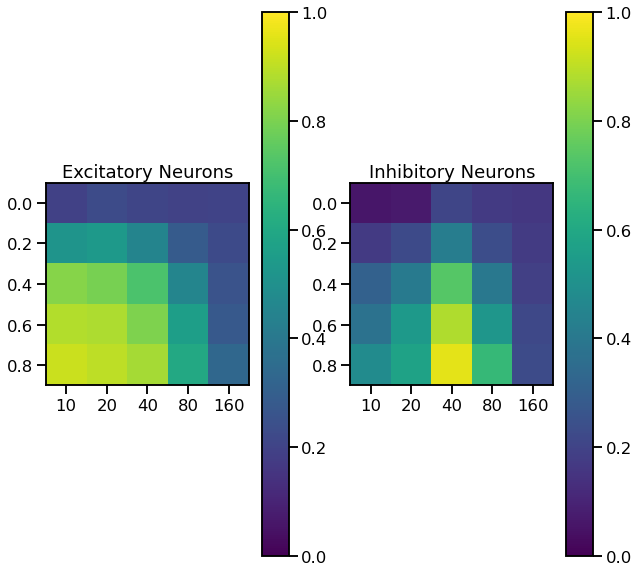

In [20]:
"""
4. 
"""
#Plot the average PLVs

#Setup figure
#Plot the average PLVs
fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(1,2)

# Average PLVs for excitatory neurons
ax = fig.add_subplot(gs[0])
im = ax.imshow(plv_exc, interpolation='none', cmap='viridis', vmin=0, vmax=1)
ax.set_title('Excitatory Neurons')
ax.set_xticks(np.arange(ext_inp_f.shape[0]))
ax.set_xticklabels(np.round(ext_inp_f, decimals=2))
ax.set_yticks(np.arange(ext_inp_rel_str.shape[0]))
ax.set_yticklabels(np.round(ext_inp_rel_str, decimals=2))
fig.colorbar(im)

# Average PLVs for inhibitory neurons
ax = fig.add_subplot(gs[1])
im = ax.imshow(plv_inh, interpolation='none', cmap='viridis', vmin=0, vmax=1)
ax.set_title('Inhibitory Neurons')
ax.set_xticks(np.arange(ext_inp_f.shape[0]))
ax.set_xticklabels(np.round(ext_inp_f, decimals=2))
ax.set_yticks(np.arange(ext_inp_rel_str.shape[0]))
ax.set_yticklabels(np.round(ext_inp_rel_str, decimals=2))
fig.colorbar(im)

Discuss these results and how they may or may not match experimental observations.

>**Answer:** TEXT HERE

<big><strong>Measuring interactions between two populations of neurons</strong></big>
<br>
<br>
<body>
Now we are going to measure how synchronous oscillations impact the flow of information from one population of neurons to the next.  For this, we will create two separate populations of neurons.  The first population will send projections into the second population through random connections.  To measure the influence of oscillations, we will measure how phase differences in population oscillations alter the transfer of an input from the first population to the second.
<br>
<br>
Here is some basic code for simulating two interacting neuron populations. 
</body>

In [4]:
#Define a function to do simulation
def SimTwoLayerNetwork(ext_inp_rel_str, phase_rel, structured_inp, ext_inp_f=10, N_exc=500, N_inh=100, T=1000):
    
    # Initialize some random arrays for generating some diversity in our neuron subtypes
    pri_perturb_exc = np.random.rand(N_exc)
    pri_perturb_inh = np.random.rand(N_inh)
    sec_perturb_exc = np.random.rand(N_exc)
    sec_perturb_inh = np.random.rand(N_inh)

    # Define our cell parameters -- same for both populations
    pri_a = np.concatenate((0.02*np.ones(N_exc), 0.12 + 0.08*pri_perturb_inh))
    pri_b = np.concatenate((0.25*np.ones(N_exc), 0.3 - 0.05*pri_perturb_inh))
    pri_c = np.concatenate((-65 + 15*pri_perturb_exc, -65*np.ones(N_inh)))
    pri_d = np.concatenate((2 - 0.5*pri_perturb_exc, 2*np.ones(N_inh)))

    sec_a = np.concatenate((0.02*np.ones(N_exc), 0.12 + 0.08*sec_perturb_inh))
    sec_b = np.concatenate((0.25*np.ones(N_exc), 0.3 - 0.05*sec_perturb_inh))
    sec_c = np.concatenate((-65 + 15*sec_perturb_exc, -65*np.ones(N_inh)))
    sec_d = np.concatenate((2 - 0.5*sec_perturb_exc, 2*np.ones(N_inh)))

    # Initialize the v and u variables
    pri_v = -65*np.ones(N_exc + N_inh) + 20*(np.random.rand(N_exc + N_inh) - 0.5)
    pri_u = pri_b*pri_v
    sec_v = -65*np.ones(N_exc + N_inh) + 20*(np.random.rand(N_exc + N_inh) - 0.5)
    sec_u = sec_b*sec_v

    # Initialize variable to keep track of spiking events for our neurons
    pri_spks = np.zeros((N_exc+N_inh, T))
    sec_spks = np.zeros((N_exc+N_inh, T))

    # External input will be a sinusoid with some noise
    # ext_inp_f defined in input
    # ext_inp_rel_str defined in input
    # phase_rel defined in input

    pri_ext_inp = np.sin(np.arange(T)/1000*2*np.pi*ext_inp_f)
    sec_ext_inp = np.sin(np.arange(T)/1000*2*np.pi*ext_inp_f + phase_rel)

    # Connection from the primary to secondary network will be random from excitatory neurons
    W = np.zeros((N_exc + N_inh, N_exc + N_inh))
    W[0:N_exc, :] = 0.1*np.random.rand(N_exc, N_exc+N_inh)

    # Simulate our networks
    for t in range(T):
        # Find which neurons are above spiking threshold
        pri_spks[pri_v>=30,t] = 1
        sec_spks[sec_v>=30,t] = 1

        # Reset these neurons v and u variables
        pri_v[pri_spks[:,t]==1] = pri_c[pri_spks[:,t]==1]
        pri_u[pri_spks[:,t]==1] = pri_u[pri_spks[:,t]==1] + pri_d[pri_spks[:,t]==1]
        sec_v[sec_spks[:,t]==1] = sec_c[sec_spks[:,t]==1]
        sec_u[sec_spks[:,t]==1] = sec_u[sec_spks[:,t]==1] + sec_d[sec_spks[:,t]==1]

        # Calculate the input to the first group of cells -- now has structured input as well as noise
        pri_S = ext_inp_rel_str*pri_ext_inp[t]*np.concatenate((5*np.ones(N_exc), 2*np.ones(N_inh))) + \
            20*structured_inp[:,t]

        # The second population has an additional drive from the first population
        if t > 0:
            sec_S = ext_inp_rel_str*sec_ext_inp[t]*np.concatenate((5*np.ones(N_exc), 2*np.ones(N_inh))) + \
                                 (W @ pri_spks[:, t-1])
        else: #first time don't have any spikes to take input from
            sec_S = ext_inp_rel_str*sec_ext_inp[t]*np.concatenate((5*np.ones(N_exc), 2*np.ones(N_inh)))

        # Update our variables -- do half ms integration of v for stability
        pri_v = pri_v + 0.5 * (0.04*np.power(pri_v, 2) + 5*pri_v + 140 - pri_u + pri_S)
        pri_v = pri_v + 0.5 * (0.04*np.power(pri_v, 2) + 5*pri_v + 140 - pri_u + pri_S)
        pri_u = pri_u + pri_a*(pri_b*pri_v - pri_u)

        sec_v = sec_v + 0.5 * (0.04*np.power(sec_v, 2) + 5*sec_v + 140 - sec_u + sec_S)
        sec_v = sec_v + 0.5 * (0.04*np.power(sec_v, 2) + 5*sec_v + 140 - sec_u + sec_S)
        sec_u = sec_u + sec_a*(sec_b*sec_v - sec_u)
    
    #Output spikes and structured input
    return (pri_spks, sec_spks, structured_inp, pri_ext_inp, sec_ext_inp)

# length of simulation
T = 1000

# number of neurons
N_exc = 500
N_inh = 100

# External input parameters
ext_inp_rel_str = 0.1 # input relative strength
phase_rel = 0 # relative phase
ext_inp_f=10 #Hz

# define structured input
# Primary cells will receive a structured input to all excitatory cells (nothing to inhibitory)
structured_inp = (np.random.rand(1, T) - 0.95)
structured_inp[np.nonzero(structured_inp < 0)] = 0
structured_inp = structured_inp/np.amax(structured_inp)
structured_inp = np.tile(structured_inp, (N_exc + N_inh, 1))

# simulate network
(pri_spks, sec_spks, structured_inp, pri_ext_inp, sec_ext_inp) = SimTwoLayerNetwork(ext_inp_rel_str,
                                                                                    phase_rel, structured_inp,
                                                                                    ext_inp_f, N_exc, N_inh, T)

<body>
Here is some code to plot the result of the simulation.  This will show the 'LFP', structured input, and spiking activity for both networks.
</body>

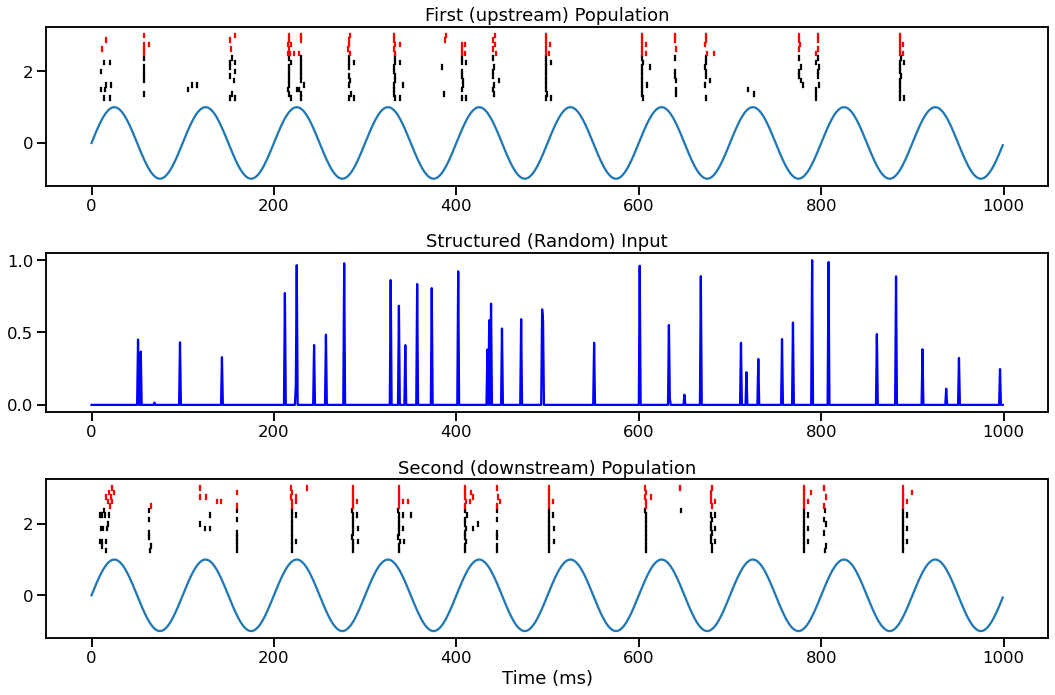

In [9]:
# Example spike rasters
fig = plt.figure(tight_layout=True, figsize=(15,10))
gs = gridspec.GridSpec(3,1)

# Create a subplot for the raster plots
ax = fig.add_subplot(gs[0])
ax.set_title('First (upstream) Population')

# Plot the sinusoidal input
plt.plot(range(T), pri_ext_inp)

# Plot some spiking events for a random subset of excitatory neurons
count = 0
for i in np.random.randint(0, N_exc+1,size=(10,1)):
    for t_spk in np.flatnonzero(pri_spks[i,:]):
        plt.plot(t_spk*np.array((1,1)), np.amax(pri_ext_inp) + 0.2 + count*0.125 + np.array((0,0.1)), 'k')
    count += 1
    
# Plot some spiking events for a random subset of inhibitory neurons
count = 0
for i in np.random.randint(0, N_exc+1,size=(5,1)):
    for t_spk in np.flatnonzero(pri_spks[i,:]):
        plt.plot(t_spk*np.array((1,1)), np.amax(pri_ext_inp) + 0.2 + 10*0.125 + count*0.125 + np.array((0,0.1)), 'r')
    count += 1

# Plot the structured input
ax = fig.add_subplot(gs[1])
ax.set_title('Structured (Random) Input')
plt.plot(range(T), structured_inp[0,:], 'b')


# Create a subplot for the raster plots
ax = fig.add_subplot(gs[2])
ax.set_title('Second (downstream) Population')
ax.set_xlabel('Time (ms)')

# Plot the sinusoidal input
plt.plot(range(T), sec_ext_inp)

# Plot some spiking events for a random subset of excitatory neurons
count = 0
for i in np.random.randint(0, N_exc+1,size=(10,1)):
    for t_spk in np.flatnonzero(sec_spks[i,:]):
        plt.plot(t_spk*np.array((1,1)), np.amax(sec_ext_inp) + 0.2 + count*0.125 + np.array((0,0.1)), 'k')
    count += 1

# Plot some spiking events for a random subset of inhibitory neurons
count = 0
for i in np.random.randint(0, N_exc+1,size=(5,1)):
    for t_spk in np.flatnonzero(sec_spks[i,:]):
        plt.plot(t_spk*np.array((1,1)), np.amax(sec_ext_inp) + 0.2 + 10*0.125 + count*0.125 + np.array((0,0.1)), 'r')
    count += 1

<body>
    To measure the influence of the structured input on the neural activity, we will measure the cross-correlation between the input and the neural activity.  Here is some example code to do this:
</body>

First neuron group had a maximum correlation of 0.40 at 4 ms.
Second neuron group had a maximum correlation of 0.29 at 8 ms.


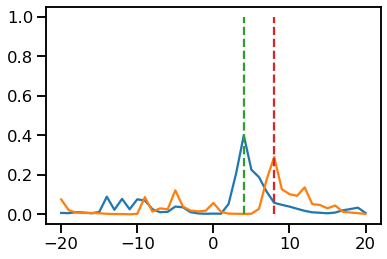

In [10]:
#Measure the cross-correlation between the populations and the structured input
pri_r = np.correlate(np.nanmean(pri_spks[0:N_exc, :], axis=0), structured_inp[0,:], mode='full')
norm_pri_r = pri_r/(np.nanstd(np.nanmean(pri_spks[0:N_exc, :], axis=0))*np.nanstd(structured_inp[0,:]))/pri_spks.shape[1]
sec_r = np.correlate(np.nanmean(sec_spks[0:N_exc, :], axis=0), structured_inp[0,:], mode='full')
norm_sec_r = sec_r/(np.nanstd(np.nanmean(sec_spks[0:N_exc, :], axis=0))*np.nanstd(structured_inp[0,:]))/sec_spks.shape[1]
lags = np.arange(-(T-1), T, 1)

#Plot the cross correlation
plot_ind = np.where((lags >= -20) & (lags <= 20))

plt.figure()
plt.plot(lags[plot_ind], norm_pri_r[plot_ind])
plt.plot(lags[plot_ind], norm_sec_r[plot_ind])

#Find the maximum location and value for each signal
pri_max_lag = np.argmax(norm_pri_r)
pri_max_r = norm_pri_r[pri_max_lag]
pri_max_lag = pri_max_lag - T + 1
print("First neuron group had a maximum correlation of %4.2f at %d ms." % (pri_max_r, pri_max_lag))

sec_max_lag = np.argmax(norm_sec_r)
sec_max_r = norm_sec_r[sec_max_lag]
sec_max_lag = sec_max_lag - T + 1
print("Second neuron group had a maximum correlation of %4.2f at %d ms." % (sec_max_r, sec_max_lag))

plt.plot(np.array((pri_max_lag, pri_max_lag)), np.array((0, 1)), '--')
plt.plot(np.array((sec_max_lag, sec_max_lag)), np.array((0, 1)), '--');

This now provides the framework for you to measure the impact of oscillations (and their synchrony) on information propagation between networks.  To this end, we will measure how correlated the spiking activity in each network is with the structured input and with one another.  

**5.** Simulate the two layer network with variable external input strengths (<code>ext_inp_rel_str </code>) and phase differences between the populations (<code>phase_rel </code>). Use input strengths in (0, 0.1, ..., 0.8, 0.9) and 10 phase differences starting at 0 and spaced in increments of $pi$ / 5. Use 500 excitatory neurons, 100 inhibitory neurons, and T = 1000 time steps for all simulations. Set the input frequency  <code>ext_inp_f</code> to 10 Hz. Importantly, make sure to use the same random structured input for each simulation. You can use the example two layer network code in the above cells to generate the structured input. 
<br>
<br>
For each simulation, compute the following quantities: 
- the maximum cross-correlation between the structured input and the first population
- the maximum cross-correlation between the structured input and the second populations
- the maximum cross-correlation between the first and second populations 
<br>
As a reminder, the code in the cell above demonstrates how to compute the cross-correlation between the structured input and the first and second populations.

Plot the maximum cross-correlation between the structured input and the first population as a function of the strength of oscillation and phase difference between populations (you can use imshow for this). Do the same for the maximum cross-correlation between the structured input and the second population, and the maximum cross-correlation between the first and second populations. In total, you should have three plots. 

In [13]:
"""
5. 
"""
## Simulation code goes here - make sure to use SimTwoLayerNetwork()
    
# Initialize the number of excitatory neurons and length of simulation
N_exc = 500
N_inh = 100
T = 1000

# External input parameters
ext_inp_rel_str = np.arange(0,1,0.1) # input relative strength
phase_rel = np.arange(0,6.28,np.pi/5) # relative phase
ext_inp_f=10 #Hz


max_corr_pri_inp = np.zeros((len(ext_inp_rel_str),len(phase_rel)))
max_corr_sec_inp = np.zeros((len(ext_inp_rel_str),len(phase_rel)))
max_corr_pri_secp = np.zeros((len(ext_inp_rel_str),len(phase_rel)))

for ext_index,ext_inp in enumerate(ext_inp_rel_str):
    for phase_index, phase in enumerate(phase_rel):
        
        # define structured input
        # Primary cells will receive a structured input to all excitatory cells (nothing to inhibitory)
        structured_inp = (np.random.rand(1, T) - 0.95)
        structured_inp[np.nonzero(structured_inp < 0)] = 0
        structured_inp = structured_inp/np.amax(structured_inp)
        structured_inp = np.tile(structured_inp, (N_exc + N_inh, 1))
        
        # simulate network
        (pri_spks, sec_spks, structured_inp, pri_ext_inp, sec_ext_inp) = SimTwoLayerNetwork(ext_inp,
                                                                                    phase, structured_inp,
                                                                                    ext_inp_f, N_exc, N_inh, T)
        
        #Measure the cross-correlation between the first populations and the structured input
        pri_r = np.correlate(np.nanmean(pri_spks[0:N_exc, :], axis=0), structured_inp[0,:], mode='full')
        norm_pri_r = pri_r/(np.nanstd(np.nanmean(pri_spks[0:N_exc, :], axis=0))*np.nanstd(structured_inp[0,:]))/pri_spks.shape[1]
        
        #Measure the cross-correlation between the second populations and the structured input
        sec_r = np.correlate(np.nanmean(sec_spks[0:N_exc, :], axis=0), structured_inp[0,:], mode='full')
        norm_sec_r = sec_r/(np.nanstd(np.nanmean(sec_spks[0:N_exc, :], axis=0))*np.nanstd(structured_inp[0,:]))/sec_spks.shape[1]
        
        #Measure the cross-correlation between the first and second populations
        pri_sec__r = np.correlate(np.nanmean(pri_spks[0:N_exc, :], axis=0), np.nanmean(sec_spks[0:N_exc, :], axis=0), mode='full')
        norm_pri_sec_r = pri_sec__r/(np.nanstd(np.nanmean(pri_spks[0:N_exc, :], axis=0))*np.nanstd(np.nanmean(sec_spks[0:N_exc, :], axis=0)))/pri_spks.shape[1]
        
        lags = np.arange(-(T-1), T, 1)
        
        #Find the maximum location and value for each signal
        pri_max_lag = np.argmax(norm_pri_r)
        pri_max_r = norm_pri_r[pri_max_lag]
        pri_max_lag = pri_max_lag - T + 1
        max_corr_pri_inp[ext_index,phase_index]=pri_max_lag
        #print("First neuron group had a maximum correlation of %4.2f at %d ms." % (pri_max_r, pri_max_lag))

        sec_max_lag = np.argmax(norm_sec_r)
        sec_max_r = norm_sec_r[sec_max_lag]
        sec_max_lag = sec_max_lag - T + 1
        max_corr_sec_inp[ext_index,phase_index]=sec_max_lag
        #print("Second neuron group had a maximum correlation of %4.2f at %d ms." % (sec_max_r, sec_max_lag))
        
        pri_sec_max_lag = np.argmax(norm_pri_sec_r)
        pri_sec_max_r = norm_pri_sec_r[pri_sec_max_lag]
        pri_sec_max_lag = pri_sec_max_lag - T + 1
        max_corr_pri_secp[ext_index,phase_index]=pri_sec_max_lag
        #print("Second neuron group had a maximum correlation of %4.2f at %d ms." % (pri_sec_max_r, pri_sec_max_lag))
        
        

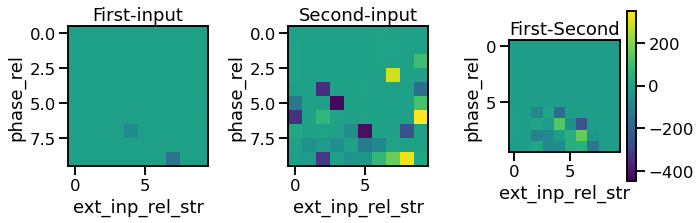

In [55]:
## Plotting code goes here
fig,axs = plt.subplots(1,3,figsize=(10,10))
#im = axs[0].imshow(max_corr_pri_inp)
#im2 = axs[1].imshow(max_corr_sec_inp)
#im3 = axs[2].imshow(max_corr_pri_secp)
#fig.colorbar(im,ax=axs.ravel().tolist(),shrink=0.25)
#fig.colorbar(im2,ax=axs.ravel().tolist(),shrink=0.25)
#fig.colorbar(im3,ax=axs.ravel().tolist(),shrink=0.25)

plt.subplot(1, 3, 1)
plt.imshow(max_corr_pri_inp, vmin=-450, vmax=350)
plt.title('First-input')
plt.xlabel("ext_inp_rel_str")
plt.ylabel("phase_rel")

plt.subplot(1, 3, 2)
plt.imshow(max_corr_sec_inp, vmin=-450, vmax=350)
plt.title('Second-input')
plt.xlabel("ext_inp_rel_str")
plt.ylabel("phase_rel")

plt.subplot(1, 3, 3)
plt.imshow(max_corr_pri_secp, vmin=-450, vmax=350)
plt.title('First-Second')
plt.xlabel("ext_inp_rel_str")
plt.ylabel("phase_rel")


plt.colorbar(shrink=0.25)
plt.tight_layout()

Finally, please provide a short answer interpreting your results -- do they look like you expect them to?  Why or why not?  What effects do you observe and what is the cause of these observed effects? How would you expect these results to change if we use 40 Hz oscillations rather than 10 Hz? 

>**Answer:** TEXT HERE

<big><strong>Measuring competition between two populations of synchronized neurons</big></strong>

<body>
Now we are going to measure how synchrony impacts the flow of information from one population to the next.  To do this, we will generalize the above code.  However, we will no longer use oscillations as our form of synchrony.  Although many experiments point to oscillatory synchrony  in the brain, the effect of synchrony can generalize beyond oscillations.<br>
<br>
To show this, we will provide a single, synchronous input to a subset of neurons in a population.  The proportion of neurons recieving the same input will determine the degree of synchrony within the network.<br>
<br>
Next, we will have that network compete with a second (also potentially synchronous network) for rerpesentation in a third, output network.  The general structure of the two layer network is depicted below.
   
</body>

<ipython-input-56-10b9b11f67b2>:15: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy=(2.25,1.75), xytext=(1,1), arrowprops=dict(arrowstyle='->'))
<ipython-input-56-10b9b11f67b2>:16: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy=(2.75,1.75), xytext=(4,1), arrowprops=dict(arrowstyle='->'))


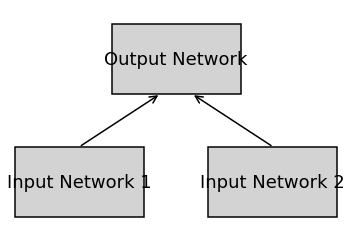

In [56]:
from matplotlib.patches import Rectangle

plt.figure()
ax = plt.axes(frameon=False)

#First network
ax.add_patch(Rectangle((0, 0), 2, 1, facecolor="lightgrey", edgecolor="black"))
ax.text(1, 0.5, 'Input Network 1', horizontalalignment='center', verticalalignment='center')
ax.add_patch(Rectangle((3, 0), 2, 1, facecolor="lightgrey", edgecolor="black"))
ax.text(4, 0.5, 'Input Network 2', horizontalalignment='center', verticalalignment='center')
ax.add_patch(Rectangle((1.5, 1.75), 2, 1, facecolor="lightgrey", edgecolor="black"))
ax.text(2.5, 2.25, 'Output Network', horizontalalignment='center', verticalalignment='center')


plt.annotate(s='', xy=(2.25,1.75), xytext=(1,1), arrowprops=dict(arrowstyle='->'))
plt.annotate(s='', xy=(2.75,1.75), xytext=(4,1), arrowprops=dict(arrowstyle='->'))

ax.set_xlim(-0.1, 5.1)
ax.set_ylim(-0.1, 3)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

<body>
We've provided some basic code for simulating this network.  Notice the common input into each 'input network' (the <code>pri_structured_inp</code> and <code>sec_structured_inp</code> variables).  These will be provided to a subset of neurons in our competing network simulation (defined by the variables <code>pri_inp_prob</code> and <code>sec_inp_prob</code>, respectively.<br>
<br>
As before, our measure of impact is going to be how correlated the downstream, output network is to the structured inputs that each network is receiving.<br>

</body>

In [57]:
## Simulation code for competing networks

# Initialize the three networks of neurons
N_exc = 500
N_inh = 100
T = 10000

# Create the structured input to all excitatory cells (nothing to inhibitory)
pri_structured_inp = (np.random.rand(T) - 0.95)
pri_structured_inp[np.nonzero(pri_structured_inp < 0)] = 0
pri_structured_inp[np.nonzero(pri_structured_inp > 0)] = 1

sec_structured_inp = (np.random.rand(T) - 0.95)
sec_structured_inp[np.nonzero(sec_structured_inp < 0)] = 0
sec_structured_inp[np.nonzero(sec_structured_inp > 0)] = 1

#Define a function to do simulation
def SimCompetingNetwork(pri_inp_prob, sec_inp_prob):
    # Initialize some random arrays for generating some diversity in our neuron subtypes
    pri_perturb_exc = np.random.rand(N_exc)
    pri_perturb_inh = np.random.rand(N_inh)
    sec_perturb_exc = np.random.rand(N_exc)
    sec_perturb_inh = np.random.rand(N_inh)
    out_perturb_exc = np.random.rand(N_exc)
    out_perturb_inh = np.random.rand(N_inh)

    # Define our cell parameters -- same for both populations
    pri_a = np.concatenate((0.02*np.ones(N_exc), 0.12 + 0.08*pri_perturb_inh))
    pri_b = np.concatenate((0.25*np.ones(N_exc), 0.3 - 0.05*pri_perturb_inh))
    pri_c = np.concatenate((-65 + 15*pri_perturb_exc, -65*np.ones(N_inh)))
    pri_d = np.concatenate((2 - 0.5*pri_perturb_exc, 2*np.ones(N_inh)))

    sec_a = np.concatenate((0.02*np.ones(N_exc), 0.12 + 0.08*sec_perturb_inh))
    sec_b = np.concatenate((0.25*np.ones(N_exc), 0.3 - 0.05*sec_perturb_inh))
    sec_c = np.concatenate((-65 + 15*sec_perturb_exc, -65*np.ones(N_inh)))
    sec_d = np.concatenate((2 - 0.5*sec_perturb_exc, 2*np.ones(N_inh)))
    
    out_a = np.concatenate((0.02*np.ones(N_exc), 0.12 + 0.08*out_perturb_inh))
    out_b = np.concatenate((0.25*np.ones(N_exc), 0.3 - 0.05*out_perturb_inh))
    out_c = np.concatenate((-65 + 15*out_perturb_exc, -65*np.ones(N_inh)))
    out_d = np.concatenate((2 - 0.5*out_perturb_exc, 2*np.ones(N_inh)))

    # Initialize the v and u variables
    pri_v = -65*np.ones(N_exc + N_inh) + 20*(np.random.rand(N_exc + N_inh) - 0.5)
    pri_u = pri_b*pri_v
    sec_v = -65*np.ones(N_exc + N_inh) + 20*(np.random.rand(N_exc + N_inh) - 0.5)
    sec_u = sec_b*sec_v
    out_v = -65*np.ones(N_exc + N_inh) + 20*(np.random.rand(N_exc + N_inh) - 0.5)
    out_u = out_b*out_v

    # Initialize variable to keep track of spiking events for our neurons
    pri_spks = np.zeros((N_exc+N_inh, T))
    sec_spks = np.zeros((N_exc+N_inh, T))
    out_spks = np.zeros((N_exc+N_inh, T))

    # Connection from the primary and secondary networks to output network will be random from excitatory neurons
    pri_W = np.zeros((N_exc + N_inh, N_exc + N_inh))
    pri_W[0:N_exc, :] = 2*np.random.rand(N_exc, N_exc+N_inh)
    sec_W = np.zeros((N_exc + N_inh, N_exc + N_inh))
    sec_W[0:N_exc, :] = 2*np.random.rand(N_exc, N_exc+N_inh)
    
    # Add recurrent weights within the output network
    rec_W = np.zeros((N_exc + N_inh, N_exc + N_inh))
    rec_W[0:N_exc, 0:N_exc] = 0*np.random.rand(N_exc, N_exc) #E->E
    rec_W[0:N_exc, N_exc:(N_exc+N_inh)] = 2*np.random.rand(N_exc, N_inh) #E->I
    rec_W[N_exc:(N_exc+N_inh), 0:N_exc] = -4*np.random.rand(N_inh, N_exc) #I->E
    rec_W[0:N_exc, N_exc:(N_exc+N_inh)] = 0*np.random.rand(N_exc, N_inh) #I->I
    
    #What neurons in primary and/or secondary inputs get the structured input?
    pri_sel = np.nonzero(np.random.rand(N_exc) <= pri_inp_prob)[0]
    sec_sel = np.nonzero(np.random.rand(N_exc) <= sec_inp_prob)[0]

    # Simulate our networks
    for t in range(T):
        # Find which neurons are above spiking threshold
        pri_spks[pri_v>=30,t] = 1
        sec_spks[sec_v>=30,t] = 1
        out_spks[out_v>=30,t] = 1

        # Reset these neurons v and u variables
        pri_v[pri_spks[:,t]==1] = pri_c[pri_spks[:,t]==1]
        pri_u[pri_spks[:,t]==1] = pri_u[pri_spks[:,t]==1] + pri_d[pri_spks[:,t]==1]
        sec_v[sec_spks[:,t]==1] = sec_c[sec_spks[:,t]==1]
        sec_u[sec_spks[:,t]==1] = sec_u[sec_spks[:,t]==1] + sec_d[sec_spks[:,t]==1]
        out_v[out_spks[:,t]==1] = out_c[out_spks[:,t]==1]
        out_u[out_spks[:,t]==1] = out_u[out_spks[:,t]==1] + out_d[out_spks[:,t]==1]

        # Calculate the input to the input networks -- some proportion will get structured input, some random
        pri_S = np.concatenate((5*np.random.rand(N_exc), 2*np.random.rand(N_inh)))
        pri_S[pri_sel] = np.repeat(10*pri_structured_inp[t], pri_sel.shape[0], axis=0)        
        sec_S = np.concatenate((5*np.random.rand(N_exc), 2*np.random.rand(N_inh)))
        sec_S[sec_sel] = np.repeat(10*sec_structured_inp[t], sec_sel.shape[0], axis=0)    
        

        # The output population has drive from both populations of neurons
        if t > 0:
            out_S = (pri_W @ pri_spks[:, t-1]) + (sec_W @ sec_spks[:, t-1]) + (rec_W @ out_spks[:, t-1])
        else: #first time don't have any spikes to take input from
            out_S = np.concatenate((5*np.ones(N_exc), 2*np.ones(N_inh)))*np.random.randn(N_exc + N_inh)

        # Update our variables -- do half ms integration of v for stability
        pri_v = pri_v + 0.5 * (0.04*np.power(pri_v, 2) + 5*pri_v + 140 - pri_u + pri_S)
        pri_v = pri_v + 0.5 * (0.04*np.power(pri_v, 2) + 5*pri_v + 140 - pri_u + pri_S)
        pri_u = pri_u + pri_a*(pri_b*pri_v - pri_u)

        sec_v = sec_v + 0.5 * (0.04*np.power(sec_v, 2) + 5*sec_v + 140 - sec_u + sec_S)
        sec_v = sec_v + 0.5 * (0.04*np.power(sec_v, 2) + 5*sec_v + 140 - sec_u + sec_S)
        sec_u = sec_u + sec_a*(sec_b*sec_v - sec_u)
        
        out_v = out_v + 0.5 * (0.04*np.power(out_v, 2) + 5*out_v + 140 - out_u + out_S)
        out_v = out_v + 0.5 * (0.04*np.power(out_v, 2) + 5*out_v + 140 - out_u + out_S)
        out_u = out_u + out_a*(out_b*out_v - out_u)
    
    #Output spikes and structured input
    return (pri_spks, sec_spks, out_spks)



#List of values to test
pri_inp_str = np.arange(0, 1.1, 0.1)
sec_inp_str = np.arange(0, 1.1, 0.1)

#Initialize our correlation variables
pri_r = np.zeros((pri_inp_str.shape[0], sec_inp_str.shape[0]))
sec_r = np.zeros((pri_inp_str.shape[0], sec_inp_str.shape[0]))

#Loop through and test different strengths 
for pri_inp_str_ind in np.arange(pri_inp_str.shape[0]):
    for sec_inp_str_ind in np.arange(sec_inp_str.shape[0]):
        #Simulate network
        (pri_spks, sec_spks, out_spks) = \
            SimCompetingNetwork(pri_inp_str[pri_inp_str_ind], sec_inp_str[sec_inp_str_ind])

        #Calculate correlation
        temp_pri_r = np.correlate(np.nanmean(out_spks[0:N_exc, :], axis=0), np.transpose(pri_structured_inp), mode='full')
        temp_pri_r = temp_pri_r/(np.nanstd(np.nanmean(out_spks[0:N_exc, :], axis=0))*np.nanstd(pri_structured_inp))/pri_spks.shape[1]
        temp_sec_r = np.correlate(np.nanmean(out_spks[0:N_exc, :], axis=0), np.transpose(sec_structured_inp), mode='full')
        temp_sec_r = temp_sec_r/(np.nanstd(np.nanmean(out_spks[0:N_exc, :], axis=0))*np.nanstd(sec_structured_inp))/sec_spks.shape[1]

        #Grab maximum correlation
        pri_r[pri_inp_str_ind, sec_inp_str_ind] = np.amax(temp_pri_r)
        sec_r[pri_inp_str_ind, sec_inp_str_ind] = np.amax(temp_sec_r)
        print("Network 1 (%4.2f); Network 2 (%4.2f): maximum correlations were %4.2f and %4.2f." \
              % (pri_inp_str[pri_inp_str_ind], sec_inp_str[sec_inp_str_ind], 
                 np.amax(temp_pri_r), np.amax(temp_sec_r)))


<ipython-input-57-5d1406b82909>:111: RuntimeWarning: overflow encountered in power
  out_v = out_v + 0.5 * (0.04*np.power(out_v, 2) + 5*out_v + 140 - out_u + out_S)
<ipython-input-57-5d1406b82909>:111: RuntimeWarning: invalid value encountered in add
  out_v = out_v + 0.5 * (0.04*np.power(out_v, 2) + 5*out_v + 140 - out_u + out_S)


Network 1 (0.00); Network 2 (0.00): maximum correlations were 0.40 and 0.38.
Network 1 (0.00); Network 2 (0.10): maximum correlations were 0.34 and 0.42.
Network 1 (0.00); Network 2 (0.20): maximum correlations were 0.29 and 0.37.
Network 1 (0.00); Network 2 (0.30): maximum correlations were 0.27 and 0.37.
Network 1 (0.00); Network 2 (0.40): maximum correlations were 0.23 and 0.34.
Network 1 (0.00); Network 2 (0.50): maximum correlations were 0.21 and 0.33.
Network 1 (0.00); Network 2 (0.60): maximum correlations were 0.20 and 0.33.
Network 1 (0.00); Network 2 (0.70): maximum correlations were 0.19 and 0.31.
Network 1 (0.00); Network 2 (0.80): maximum correlations were 0.18 and 0.30.
Network 1 (0.00); Network 2 (0.90): maximum correlations were 0.17 and 0.30.
Network 1 (0.00); Network 2 (1.00): maximum correlations were 0.17 and 0.29.
Network 1 (0.10); Network 2 (0.00): maximum correlations were 0.41 and 0.31.
Network 1 (0.10); Network 2 (0.10): maximum correlations were 0.35 and 0.35.

Network 1 (0.90); Network 2 (0.80): maximum correlations were 0.22 and 0.21.
Network 1 (0.90); Network 2 (0.90): maximum correlations were 0.22 and 0.20.
Network 1 (0.90); Network 2 (1.00): maximum correlations were 0.21 and 0.21.
Network 1 (1.00); Network 2 (0.00): maximum correlations were 0.31 and 0.15.
Network 1 (1.00); Network 2 (0.10): maximum correlations were 0.31 and 0.16.
Network 1 (1.00); Network 2 (0.20): maximum correlations were 0.28 and 0.16.
Network 1 (1.00); Network 2 (0.30): maximum correlations were 0.27 and 0.17.
Network 1 (1.00); Network 2 (0.40): maximum correlations were 0.27 and 0.17.
Network 1 (1.00); Network 2 (0.50): maximum correlations were 0.25 and 0.20.
Network 1 (1.00); Network 2 (0.60): maximum correlations were 0.24 and 0.19.
Network 1 (1.00); Network 2 (0.70): maximum correlations were 0.24 and 0.20.
Network 1 (1.00); Network 2 (0.80): maximum correlations were 0.23 and 0.20.
Network 1 (1.00); Network 2 (0.90): maximum correlations were 0.23 and 0.20.

Once you've run the code, now you can plot the effect of synchrony on information propagation below.  
<br>
**6.** Using the outputs of the above simulation, provide a plot of the correlation of the output network to both the primary and secondary structured input.  Plot this as a function of the probability of a neuron receiving a structured input in the primary and secondary populations.  

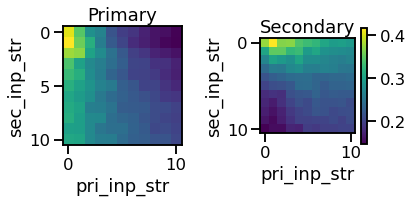

In [62]:
"""
6. 
"""
## PLOTTING CODE SHOULD GO HERE


plt.subplot(1,2 , 1)
plt.imshow(pri_r)
plt.title('Primary')
plt.xlabel("pri_inp_str")
plt.ylabel("sec_inp_str")

plt.subplot(1, 2, 2)
plt.imshow(sec_r)               #, vmin=-450, vmax=350
plt.title('Secondary')
plt.xlabel("pri_inp_str")
plt.ylabel("sec_inp_str")


plt.colorbar(shrink=0.5)
plt.tight_layout()


Next, on three different imshow plots, plot the correlation of the output network to both inputs separately and then plot the difference in correlation. All three of these plots should be as a function of the two input network strengths. (hint: the baseline correlation for the two networks may be different because of differences in the inputs, so make sure to normalize when computing the difference in correlation. You should be able to create all of these plots using the variables output from the simulations above.)

In [ ]:
## PLOTTING CODE SHOULD GO HERE



Interpret your results.  What is synchrony doing to the signal?  Is it helping to pass the signal along?  If not, why not?  How are the two networks competing?  How does increasing synchrony in one region impact the other signal?

> **Answer:** TEXT HERE

Lastly, discuss why, based on all of your results, synchrony could be a good and/or bad thing.

> **Answer:** TEXT HERE